In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

import tensorflow as tf
from tensorflow.contrib.keras import backend
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import applications

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

In [5]:
from google.colab import files

uploaded = files.upload()


Saving image.jpg to image.jpg
Saving style.png to style.png


# New Section

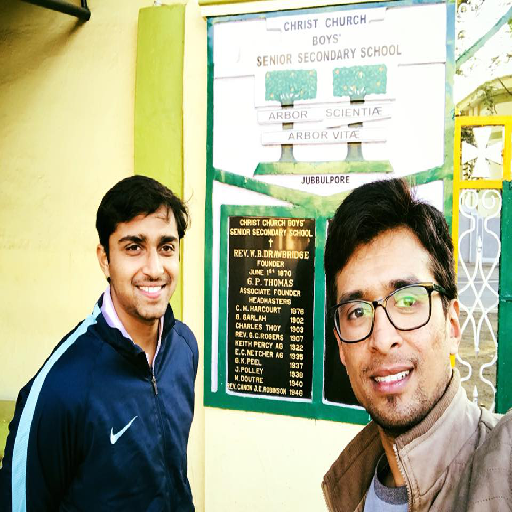

In [6]:
height = 512
width = 512

content_image_path = 'image.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

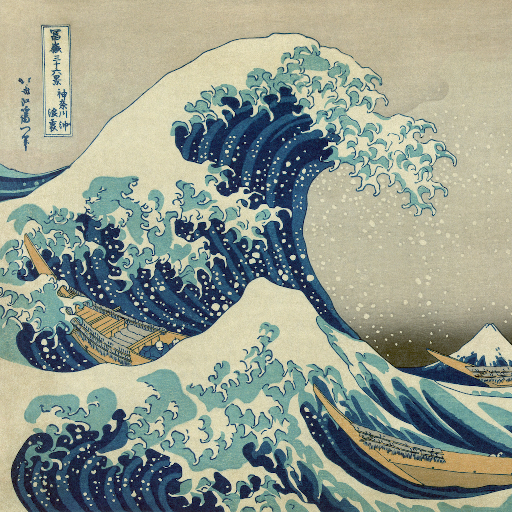

In [7]:
style_image_path = 'style.png'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

In [0]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)


In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [0]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [12]:
model = applications.VGG16(input_tensor=input_tensor, weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 6s 0us/step


In [0]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
loss = backend.variable(0.)

In [0]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features, combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)


In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [25]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 80642560000.0
Iteration 0 completed in 22s
Start of iteration 1
Current loss value: 37048230000.0
Iteration 1 completed in 17s
Start of iteration 2
Current loss value: 27866505000.0
Iteration 2 completed in 17s
Start of iteration 3
Current loss value: 24783650000.0
Iteration 3 completed in 18s
Start of iteration 4
Current loss value: 23725849000.0
Iteration 4 completed in 18s
Start of iteration 5
Current loss value: 23198122000.0
Iteration 5 completed in 18s
Start of iteration 6
Current loss value: 22906208000.0
Iteration 6 completed in 18s
Start of iteration 7
Current loss value: 22735114000.0
Iteration 7 completed in 18s
Start of iteration 8
Current loss value: 22638210000.0
Iteration 8 completed in 18s
Start of iteration 9
Current loss value: 22578530000.0
Iteration 9 completed in 18s


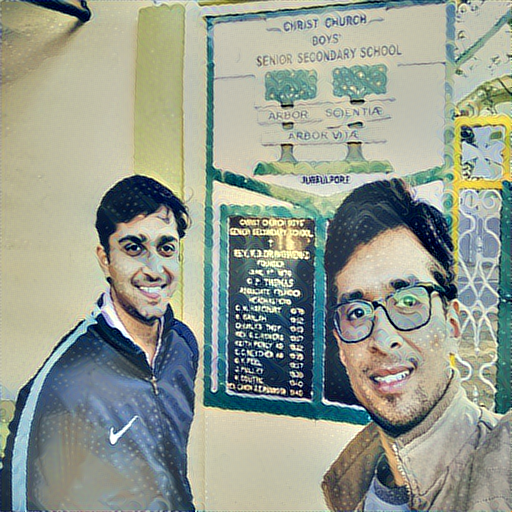

In [26]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)